## Import Libraries and Data

In [13]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_17-27-04-23.csv', firstRow=354, lastRow=360)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_250423_S355-360.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [14]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=48s and ended at t=372s; mass=45.965650000000004g
This equals a volume of 46.058m; expected was 46.153mL; error is 0.205%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001666666666666667 g/s and for 2nd derivative = 0.0005833333333333335 g/s^2


<IPython.core.display.Javascript object>


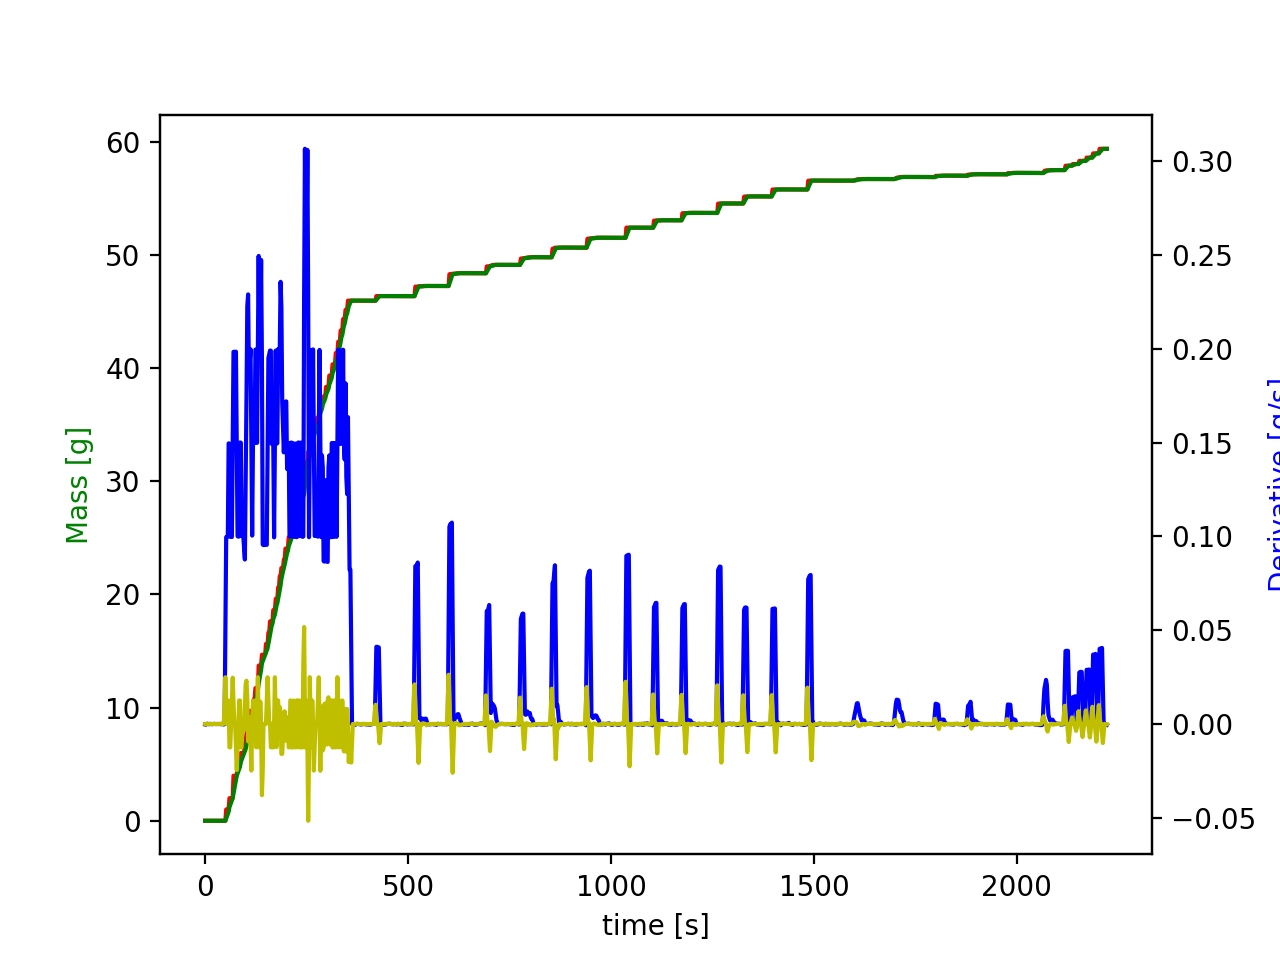

Addition of 0.41g Texapon SB 3 KC detected from 416s to 436s - expected volume = 0.781mL and actual volume = 0.367mL (resulting error is 52.928%)
Addition of 0.9g Plantapon ACG 50 detected from 512s to 550s - expected volume = 0.844mL and actual volume = 0.797mL (resulting error is 5.618%)
Addition of 1.137g Plantapon ACG 50 detected from 596s to 632s - expected volume = 0.949mL and actual volume = 1.007mL (resulting error is 6.181%)
Addition of 0.742g Plantapon LC 7 detected from 688s to 722s - expected volume = 0.965mL and actual volume = 0.701mL (resulting error is 27.365%)
Addition of 0.68g Plantacare 818 detected from 772s to 812s - expected volume = 0.77mL and actual volume = 0.619mL (resulting error is 19.61%)
Addition of 0.856g Plantacare 818 detected from 850s to 876s - expected volume = 0.756mL and actual volume = 0.788mL (resulting error is 4.312%)
Addition of 0.874g Plantacare 2000 detected from 936s to 976s - expected volume = 0.957mL and actual volume = 0.8mL (resulting e

In [15]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.001666666666666667 g/s and for 2nd derivative = 0.0005208333333333334 g/s^2


<IPython.core.display.Javascript object>


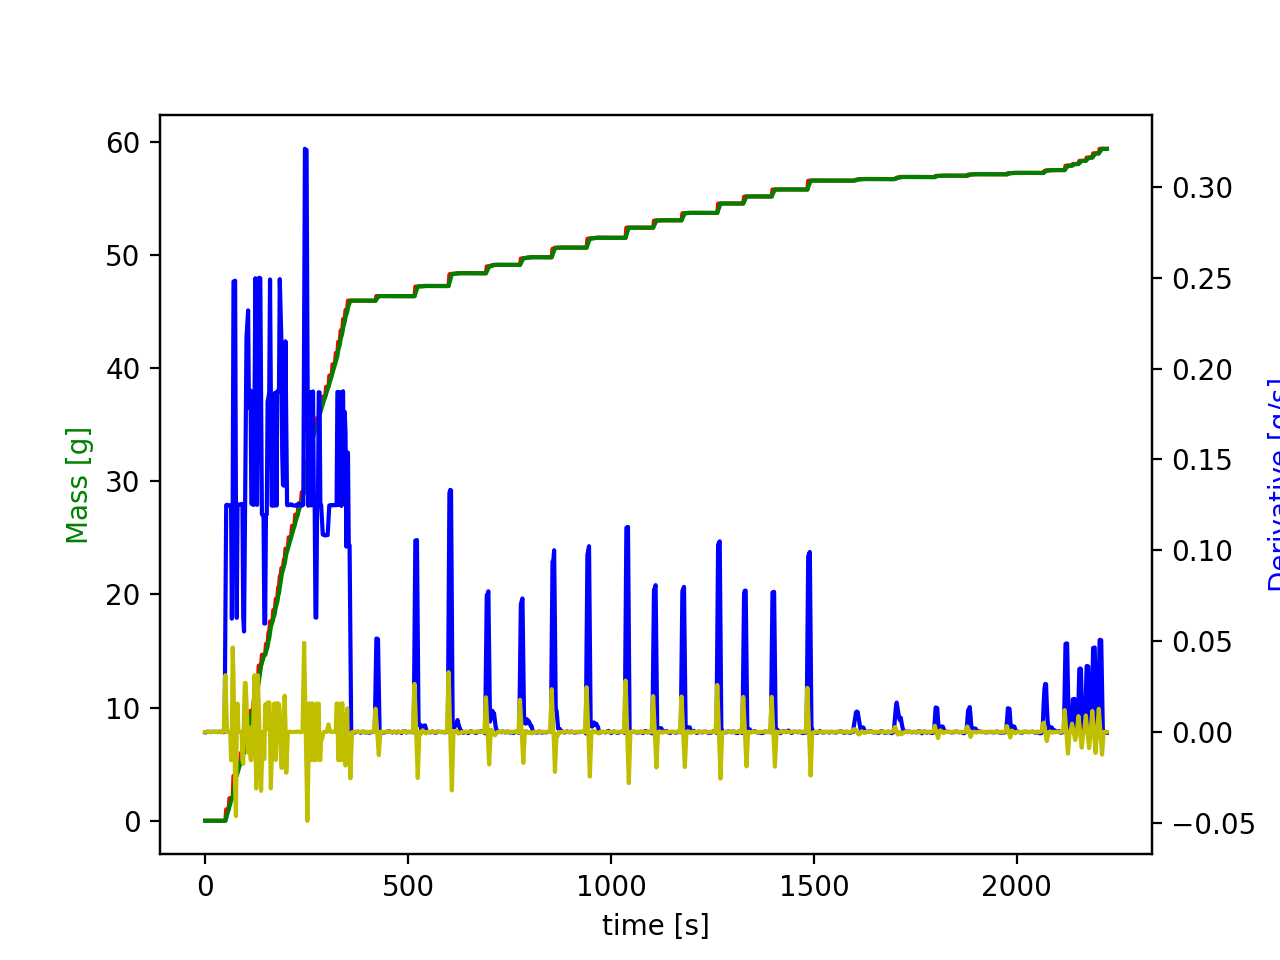

Addition of 0.148g Dehyquart CC7 Benz detected from 1594s to 1628s - expected volume = 0.159mL and actual volume = 0.145mL (resulting error is 8.796%)
Addition of 0.189g Dehyquart CC7 Benz detected from 1694s to 1724s - expected volume = 0.185mL and actual volume = 0.186mL (resulting error is 0.465%)
Addition of 0.125g Dehyquart CC7 Benz detected from 1794s to 1824s - expected volume = 0.123mL and actual volume = 0.122mL (resulting error is 0.4%)
Addition of 0.131g Dehyquart CC7 Benz detected from 1874s to 1902s - expected volume = 0.121mL and actual volume = 0.13mL (resulting error is 7.275%)
Addition of 0.127g Dehyquart CC7 Benz detected from 1972s to 2000s - expected volume = 0.111mL and actual volume = 0.125mL (resulting error is 13.17%)
Addition of 0.252g Dehyquart CC7 Benz detected from 2060s to 2090s - expected volume = 0.243mL and actual volume = 0.25mL (resulting error is 2.908%)


In [16]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.0025 g/s^2


<IPython.core.display.Javascript object>


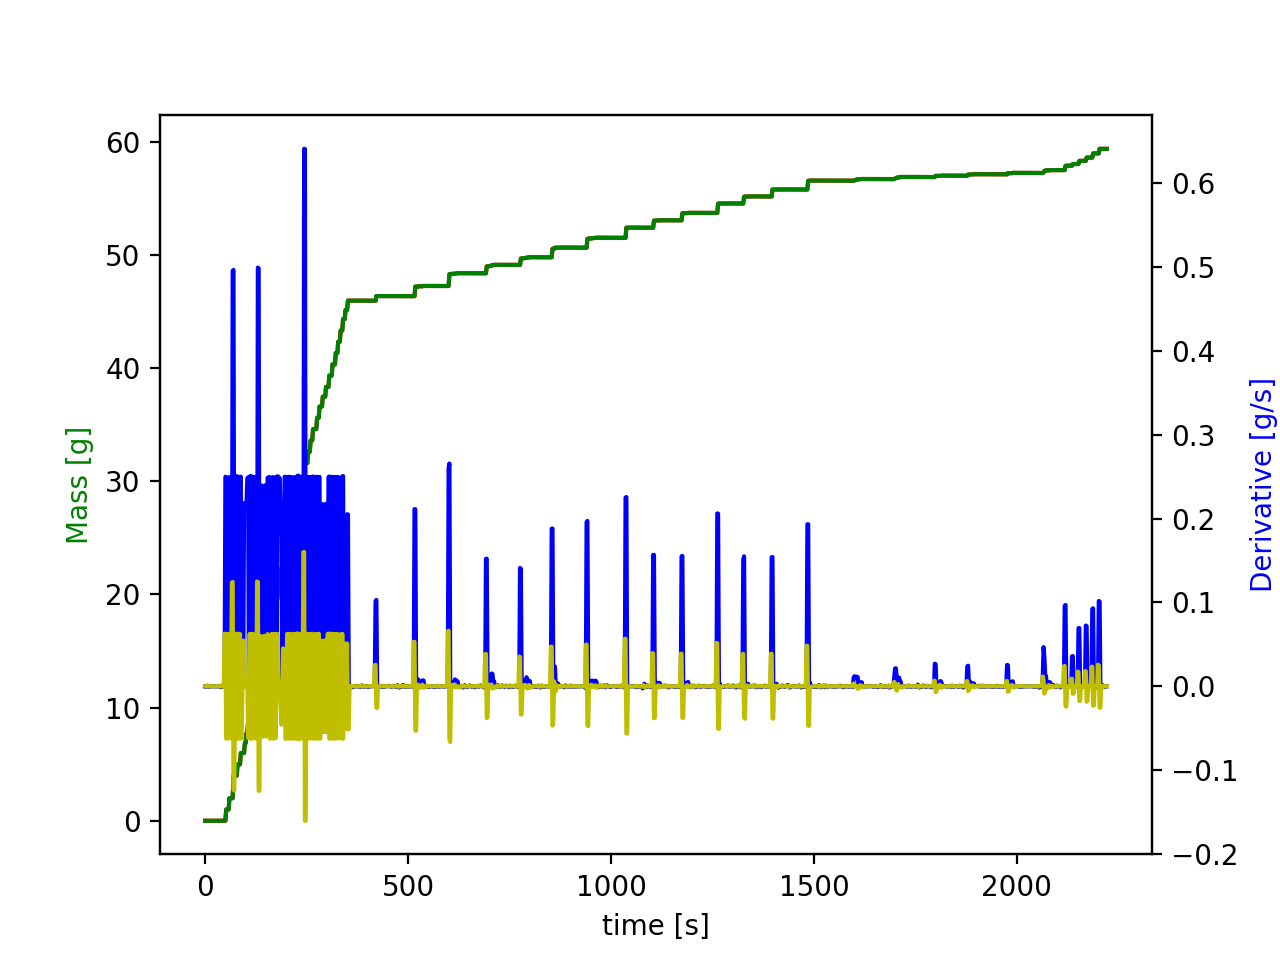

Addition of 0.393g Arlypon F detected from 2114s to 2126s - expected volume = 0.442mL and actual volume = 0.445mL (resulting error is 0.769%)
Addition of 0.147g Arlypon F detected from 2132s to 2144s - expected volume = 0.148mL and actual volume = 0.168mL (resulting error is 13.462%)
Addition of 0.275g Arlypon F detected from 2148s to 2160s - expected volume = 0.291mL and actual volume = 0.311mL (resulting error is 6.809%)
Addition of 0.291g Arlypon F detected from 2166s to 2178s - expected volume = 0.309mL and actual volume = 0.333mL (resulting error is 7.778%)
Addition of 0.373g Arlypon F detected from 2182s to 2194s - expected volume = 0.399mL and actual volume = 0.426mL (resulting error is 6.714%)
Addition of 0.401g Arlypon F detected from 2198s to 2210s - expected volume = 0.432mL and actual volume = 0.459mL (resulting error is 6.233%)


In [17]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [18]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_250423_S355-S360.csv', index=False)
actualMassFractions

,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
354,355.0,0.000000,0.000000,0.000000,6.884754,0.00000,0.0,0.000000,0.0,8.464978,0.0,0.000000,0.0,0.0,0.0,1.495695,0.0,3.978398,0.0
355,356.0,0.000000,0.000000,0.000000,0.000000,8.79471,0.0,0.000000,0.0,0.000000,0.0,7.961527,0.0,0.0,0.0,1.900573,0.0,1.484233,0.0
356,357.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,8.908315,0.0,12.352917,0.0,0.000000,0.0,0.0,0.0,1.235887,0.0,2.724908,0.0
357,358.0,0.000000,8.833090,0.000000,0.000000,0.00000,0.0,12.885677,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.283908,0.0,2.854764,0.0
358,359.0,4.355859,0.000000,7.878792,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.346598,0.0,3.968081,0.0
359,360.0,0.000000,11.059691,0.000000,8.328807,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.452009,0.0,3.895011,0.0
